In [0]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [6]:
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 463412.72it/s]


In [11]:
fb_df.drop_duplicates()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398
...,...,...
2097,597,611
2098,601,603
2099,601,616
2100,603,616


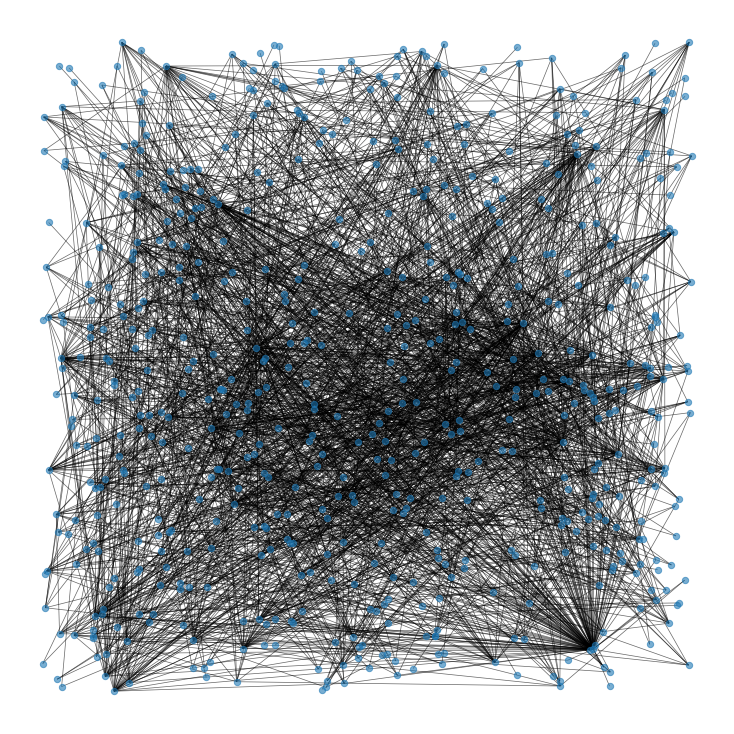

In [10]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [107]:

# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)



100%|██████████| 2102/2102 [00:11<00:00, 183.85it/s]


In [108]:
data['link'].value_counts()


0    19018
1     1483
Name: link, dtype: int64

In [0]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [111]:
!pip install Node2Vec

In [112]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:19<00:00,  2.49it/s]


In [114]:
n2w_model['1']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.137738  ,  0.12073945, -0.8066023 , -0.11692102,  1.216517  ,
       -0.4762159 ,  0.99373   ,  0.37223512,  1.1225789 , -0.4435114 ,
       -0.28217027, -0.14675982,  0.68641925, -1.3939886 , -0.0927369 ,
        1.0872855 ,  1.2328784 , -0.33805895, -0.3892469 , -0.23523632,
        0.33792812,  0.31176084, -1.5496795 , -1.7821541 , -0.5352325 ,
       -0.70727664,  0.36058435, -0.06421898,  0.69263685,  0.11514916,
        0.06687222,  0.42756686,  0.53427905,  0.26806992,  0.6072034 ,
       -0.41272235,  0.22033443,  0.8055175 ,  0.3272516 ,  0.5847288 ,
       -0.5377145 , -0.9834703 ,  0.15996617, -0.36845306,  0.4378532 ,
        1.199858  ,  0.02807981, -0.1768997 , -0.75911754, -0.3196292 ,
        0.06846704, -0.2619307 ,  0.14454883, -0.4823376 ,  0.5403801 ,
       -0.7985929 ,  1.1170591 ,  0.2740842 , -0.53806376,  0.9273633 ,
       -0.00658629, -0.6656275 , -0.6787269 ,  0.09414955,  0.3378635 ,
        0.32575595, -0.4834349 , -0.06285276,  1.2560779 ,  0.32

In [124]:
embeddings = []
for nodes in set(list(fb_df_partial['node_1'].values)  + list(fb_df_partial['node_2'].values)):
  embeddings.append(n2w_model[nodes])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(embeddings)

In [127]:
kmeans.labels_

array([1, 9, 0, 6, 9, 6, 9, 6, 6, 0, 6, 5, 6, 4, 7, 4, 7, 1, 9, 6, 6, 6,
       2, 6, 6, 6, 1, 9, 0, 6, 6, 1, 7, 4, 6, 6, 0, 9, 2, 6, 6, 0, 9, 3,
       6, 6, 6, 5, 1, 6, 6, 6, 6, 0, 6, 8, 8, 9, 6, 6, 1, 7, 8, 7, 9, 6,
       0, 2, 6, 7, 3, 2, 6, 6, 6, 5, 6, 6, 9, 2, 0, 3, 1, 6, 6, 6, 5, 1,
       2, 6, 4, 6, 1, 6, 7, 3, 2, 9, 2, 7, 3, 8, 6, 6, 6, 9, 0, 8, 8, 6,
       7, 8, 6, 0, 6, 7, 6, 4, 1, 4, 6, 5, 2, 6, 1, 6, 6, 6, 9, 9, 7, 1,
       9, 6, 0, 6, 9, 1, 9, 0, 7, 6, 9, 8, 6, 6, 6, 9, 6, 8, 6, 6, 6, 6,
       5, 5, 0, 9, 2, 0, 8, 4, 6, 6, 1, 6, 6, 6, 0, 0, 6, 6, 8, 0, 0, 1,
       8, 6, 0, 8, 7, 9, 9, 6, 1, 0, 2, 6, 0, 3, 2, 9, 9, 3, 6, 4, 6, 6,
       6, 0, 4, 6, 6, 6, 6, 1, 6, 6, 8, 6, 4, 6, 0, 6, 8, 8, 9, 6, 1, 0,
       6, 6, 8, 0, 0, 8, 6, 6, 9, 2, 6, 2, 6, 7, 1, 6, 6, 1, 4, 6, 8, 7,
       9, 6, 6, 8, 1, 5, 6, 6, 0, 3, 8, 6, 4, 6, 6, 6, 9, 6, 5, 0, 6, 6,
       4, 9, 1, 2, 9, 6, 6, 6, 7, 6, 9, 3, 8, 5, 0, 3, 6, 2, 7, 2, 6, 8,
       3, 6, 8, 6, 6, 8, 2, 0, 6, 6, 6, 8, 0, 8, 5,

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [134]:
pca.explained_variance_ratio_

array([0.07562332, 0.06936948])

In [133]:
pca.singular_values_

array([46.06407457, 44.11829301])

In [0]:
points = pca.transform(embeddings)

[]

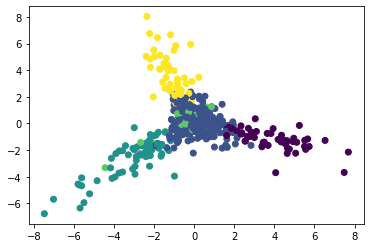

In [140]:
plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_)
plt.plot()

In [144]:
x = np.array([(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])])

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)
predictions = lr.predict_proba(xtest)
fpr, tpr, thresholds = roc_curve(ytest, predictions[:,1])
score = roc_auc_score(ytest, predictions[:,1])

precision, recall, thresholds_ = precision_recall_curve(ytest, predictions[:,1])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


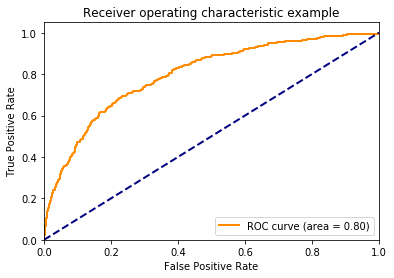

No handles with labels found to put in legend.


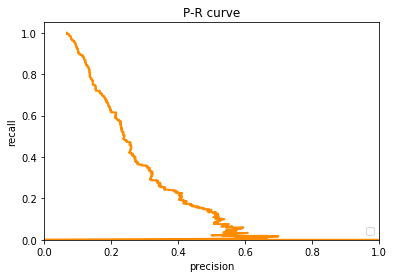

In [161]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.figure()

plt.plot(precision, recall, color='darkorange',
         lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('P-R curve')
plt.legend(loc="lower right")
plt.show()